In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sunpy.cm as cm
from astropy.io import fits
import sunpy.map
import astropy.units as u
import scipy as sp
from pprint import pprint
import glob
from astropy.coordinates import SkyCoord
%matplotlib inline

# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

# Color Axis limits
vmin = -2000
vmax = 2000

In [4]:
HMIfile = 'Data/HMI/hmi.M_720s.20110401_000000_TAI.1.magnetogram.fits'

HMI_fits = fits.open(HMIfile, cache=False)
HMI_fits.verify('fix')
dataHMI = HMI_fits[1].data

HMImap = sunpy.map.Map(HMI_fits[1].data, HMI_fits[1].header)
HMImap = HMImap.rotate(rmatrix=HMImap.rotation_matrix, missing=np.nan, recenter=True)

# Apply NaNs for Pixels outside the Sun
x, y = np.meshgrid(*[np.arange(v.value) for v in HMImap.dimensions]) * u.pixel
hpc_coords = HMImap.pixel_to_world(x, y)
r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / HMImap.rsun_obs
HMImap.data[r>1] = np.nan

In [5]:
MDIfile = 'Data/MDI/mdi.fd_M_96m_lev182.20110401_000000_TAI.data.fits'

MDI_fits = fits.open(MDIfile, cache=False)
dataMDI = MDI_fits[1].data

MDImap = sunpy.map.Map(MDI_fits[1].data, MDI_fits[1].header)
MDImap = MDImap.rotate(rmatrix=MDImap.rotation_matrix, missing=np.nan, recenter=True)

x, y = np.meshgrid(*[np.arange(v.value) for v in MDImap.dimensions]) * u.pixel
hpc_coords = MDImap.pixel_to_world(x, y)
r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / MDImap.rsun_obs
MDImap.data[r>1] = np.nan

MDImap = MDImap.submap(HMImap.bottom_left_coord,HMImap.top_right_coord)

In [6]:
SOTfile = 'Data/SOT/20110401_002004.fits'

SOT_fits = fits.open(SOTfile, cache=False)
dataSOT = SOT_fits[1].data
dataSOT = np.cos(SOT_fits[2].data*np.pi/180)*SOT_fits[1].data

# Adding missing header information
header = SOT_fits[0].header
header['cunit1'] = 'arcsec'
header['cunit2'] = 'arcsec'
header['CDELT1'] = header['XSCALE']
header['CDELT2'] = header['YSCALE']
header['CRVAL1'] = header['XCEN']
header['CRVAL2'] = header['YCEN']
header['RSUN_OBS'] = header['SOLAR_RA']
header['CROTA2'] = header['B_ANGLE']
header['CRPIX1'] = dataSOT.shape[1]/2
header['CRPIX2'] = dataSOT.shape[0]/2

SOTmap = sunpy.map.Map(dataSOT, header)

# SOTmap = SOTmap.rotate(angle=header['B_ANGLE']*u.degree, missing=np.nan)

x, y = np.meshgrid(*[np.arange(v.value) for v in SOTmap.dimensions]) * u.pixel
hpc_coords = SOTmap.pixel_to_world(x, y)
r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / SOTmap.rsun_obs
SOTmap.data[r>1] = np.nan

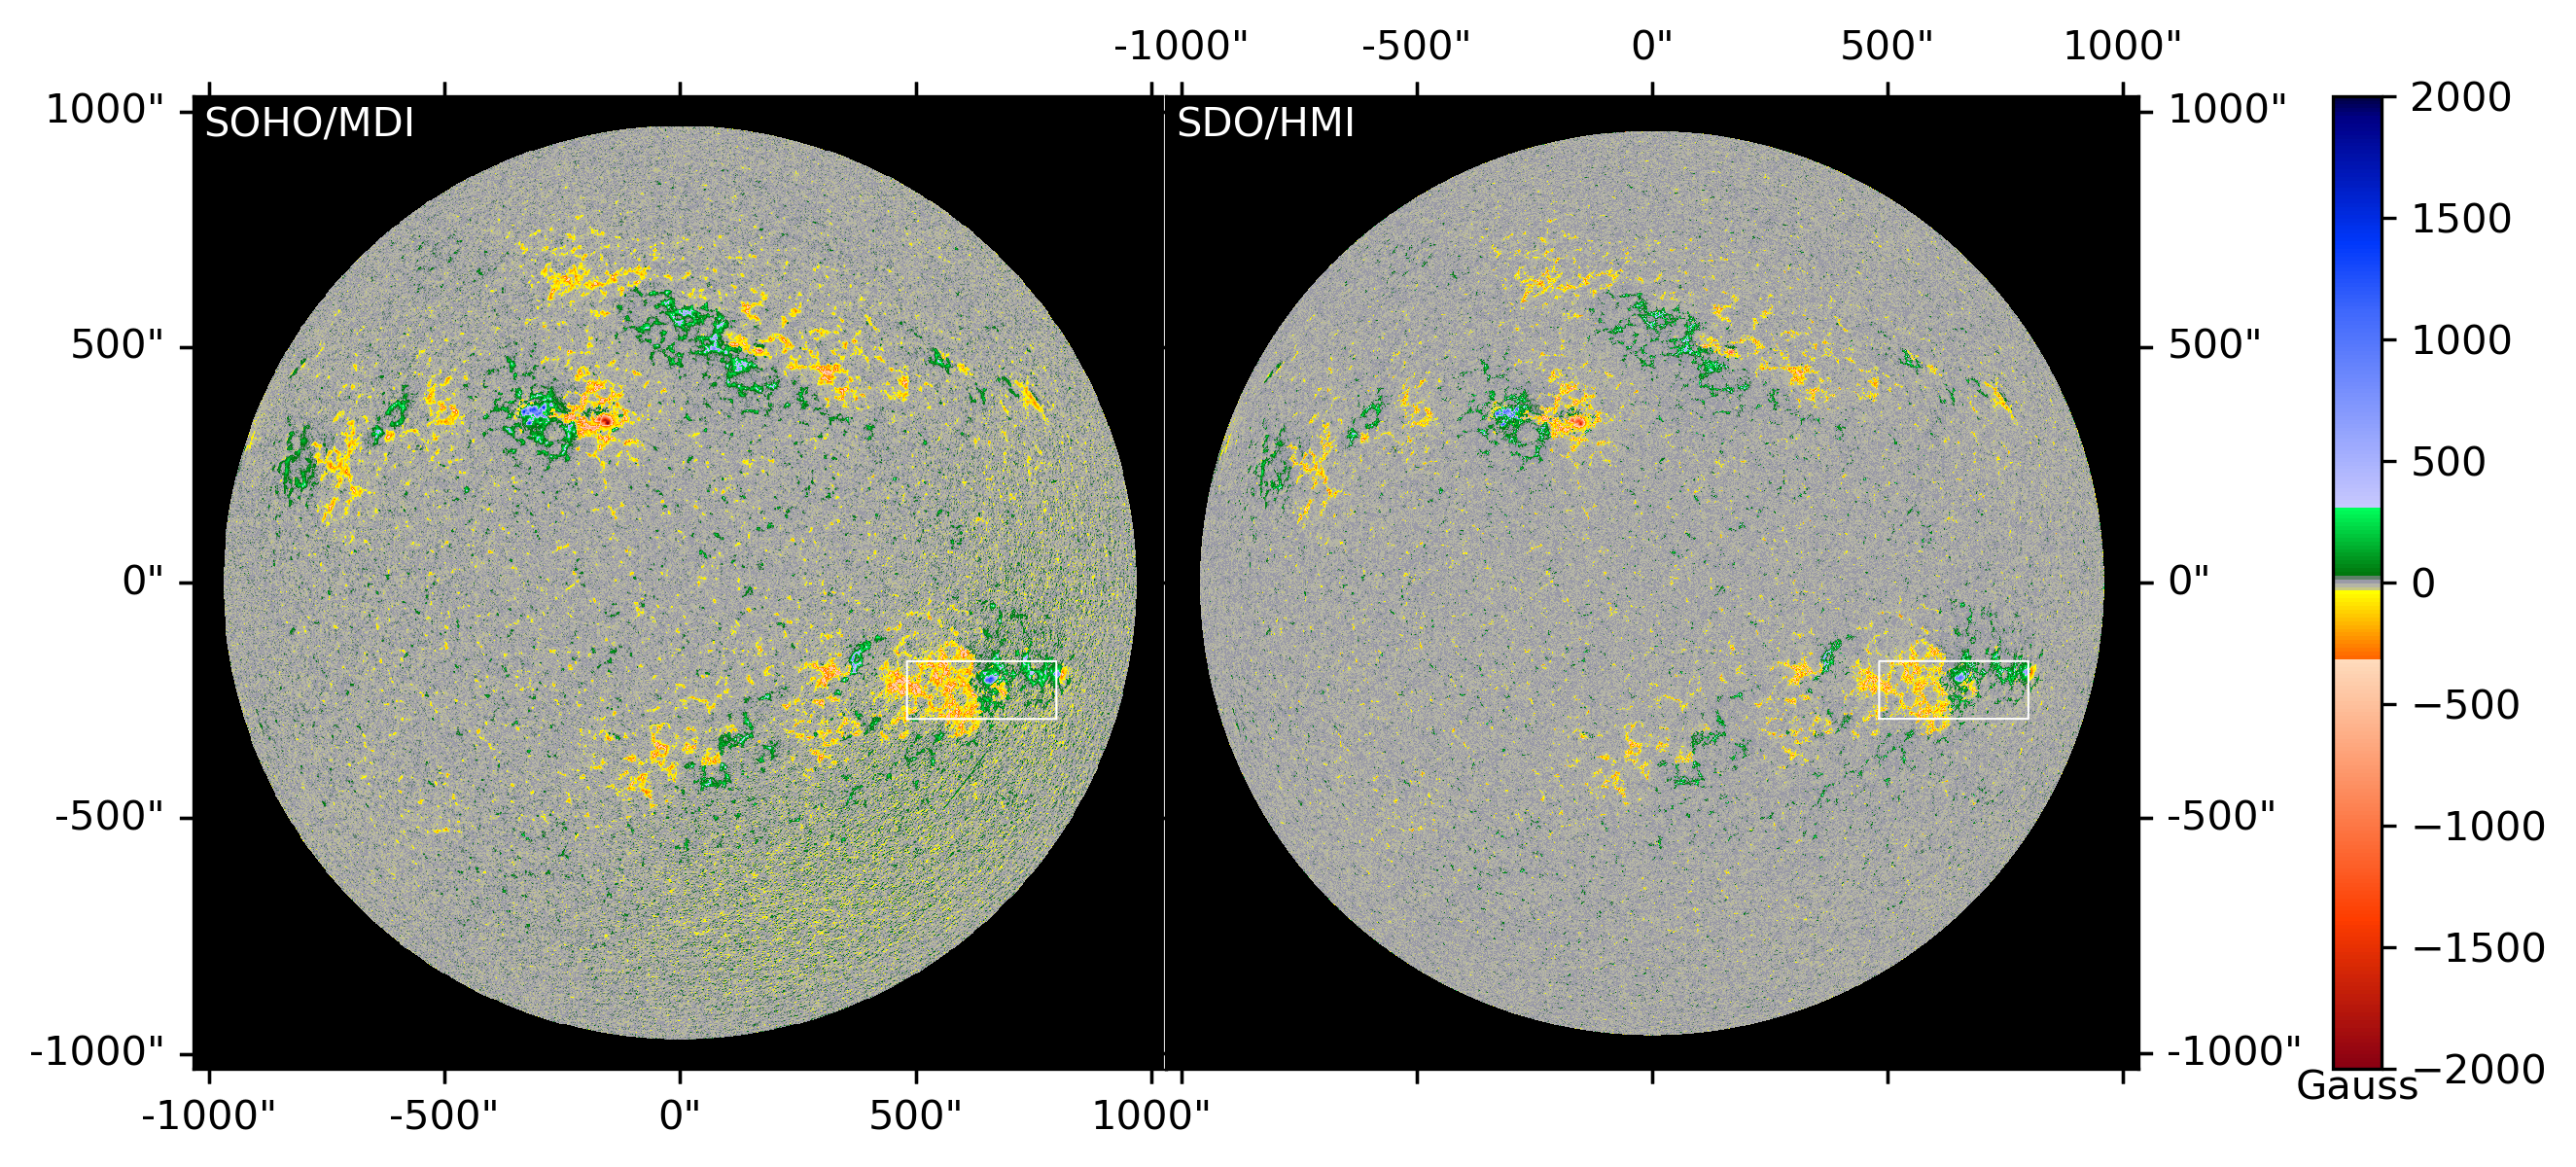

In [7]:
# Size definitions
dpi = 300
pxx = 1000   # Horizontal size of each panel
pxy = pxx   # Vertical size of each panel

nph = 2     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units

# Colormaps
current_cmap = plt.cm.get_cmap('hmimag')
current_cmap.set_bad(color='black')

## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)
ax1 = fig.add_axes([ppadh, ppadv, ppxx, ppxy], projection=MDImap)

x, y = np.meshgrid(*[np.arange(v.value) for v in MDImap.dimensions]) * u.pixel
hpc_coords = MDImap.pixel_to_world(x, y)
ax1.pcolormesh(x, y, MDImap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
ax1.grid(False)

# Plot SOT field of view
xSOT = [SOTmap.bottom_left_coord.Tx, SOTmap.bottom_left_coord.Tx, SOTmap.top_right_coord.Tx, SOTmap.top_right_coord.Tx, SOTmap.bottom_left_coord.Tx]
ySOT = [SOTmap.bottom_left_coord.Ty, SOTmap.top_right_coord.Ty, SOTmap.top_right_coord.Ty, SOTmap.bottom_left_coord.Ty, SOTmap.bottom_left_coord.Ty]
coord = SkyCoord(xSOT, ySOT, frame=MDImap.coordinate_frame)
ax1.plot_coord(coord,'w',linewidth = 0.5)

ax1.text(0.01, 0.99, 'SOHO/MDI', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax1.transAxes)

ax2 = fig.add_axes([ppadh+ppxx, ppadv, ppxx, ppxy], projection=HMImap)

x, y = np.meshgrid(*[np.arange(v.value) for v in HMImap.dimensions]) * u.pixel
hpc_coords = HMImap.pixel_to_world(x, y)
mesh = ax2.pcolormesh(x, y, HMImap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
coord = SkyCoord(xSOT, ySOT, frame=HMImap.coordinate_frame)
ax2.plot_coord(coord,'w',linewidth = 0.5)
ax2.grid(False)

ax2.text(0.01, 0.99, 'SDO/HMI', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax2.transAxes)


lon = ax2.coords[0]
lon.set_ticklabel_position('t')
lat = ax2.coords[1]
lat.set_ticklabel_position('r')

axcb = fig.add_axes([ppadh+4*ppadh2+2*ppxx, ppadv, ppadh2, ppxy])
cmap = current_cmap
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(axcb, cmap=cmap,
                                norm=norm)

axcb.text(0.5, 0, 'Gauss', horizontalalignment='center', verticalalignment='top', color = 'k', transform=axcb.transAxes);


In [8]:
HMIfile = 'Data/HMI/hmi.M_720s.20110401_002400_TAI.1.magnetogram.fits'

HMI_fits = fits.open(HMIfile, cache=False)
HMI_fits.verify('fix')
dataHMI = HMI_fits[1].data

HMImap = sunpy.map.Map(HMI_fits[1].data, HMI_fits[1].header)
HMImap = HMImap.rotate(rmatrix=HMImap.rotation_matrix, missing=np.nan, recenter=True)

# Apply NaNs for Pixels outside the Sun
x, y = np.meshgrid(*[np.arange(v.value) for v in HMImap.dimensions]) * u.pixel
hpc_coords = HMImap.pixel_to_world(x, y)
r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / HMImap.rsun_obs
HMImap.data[r>1] = np.nan

In [9]:
MDISmap = MDImap.submap(SOTmap.bottom_left_coord,SOTmap.top_right_coord)
HMISmap = HMImap.submap(SOTmap.bottom_left_coord,SOTmap.top_right_coord)

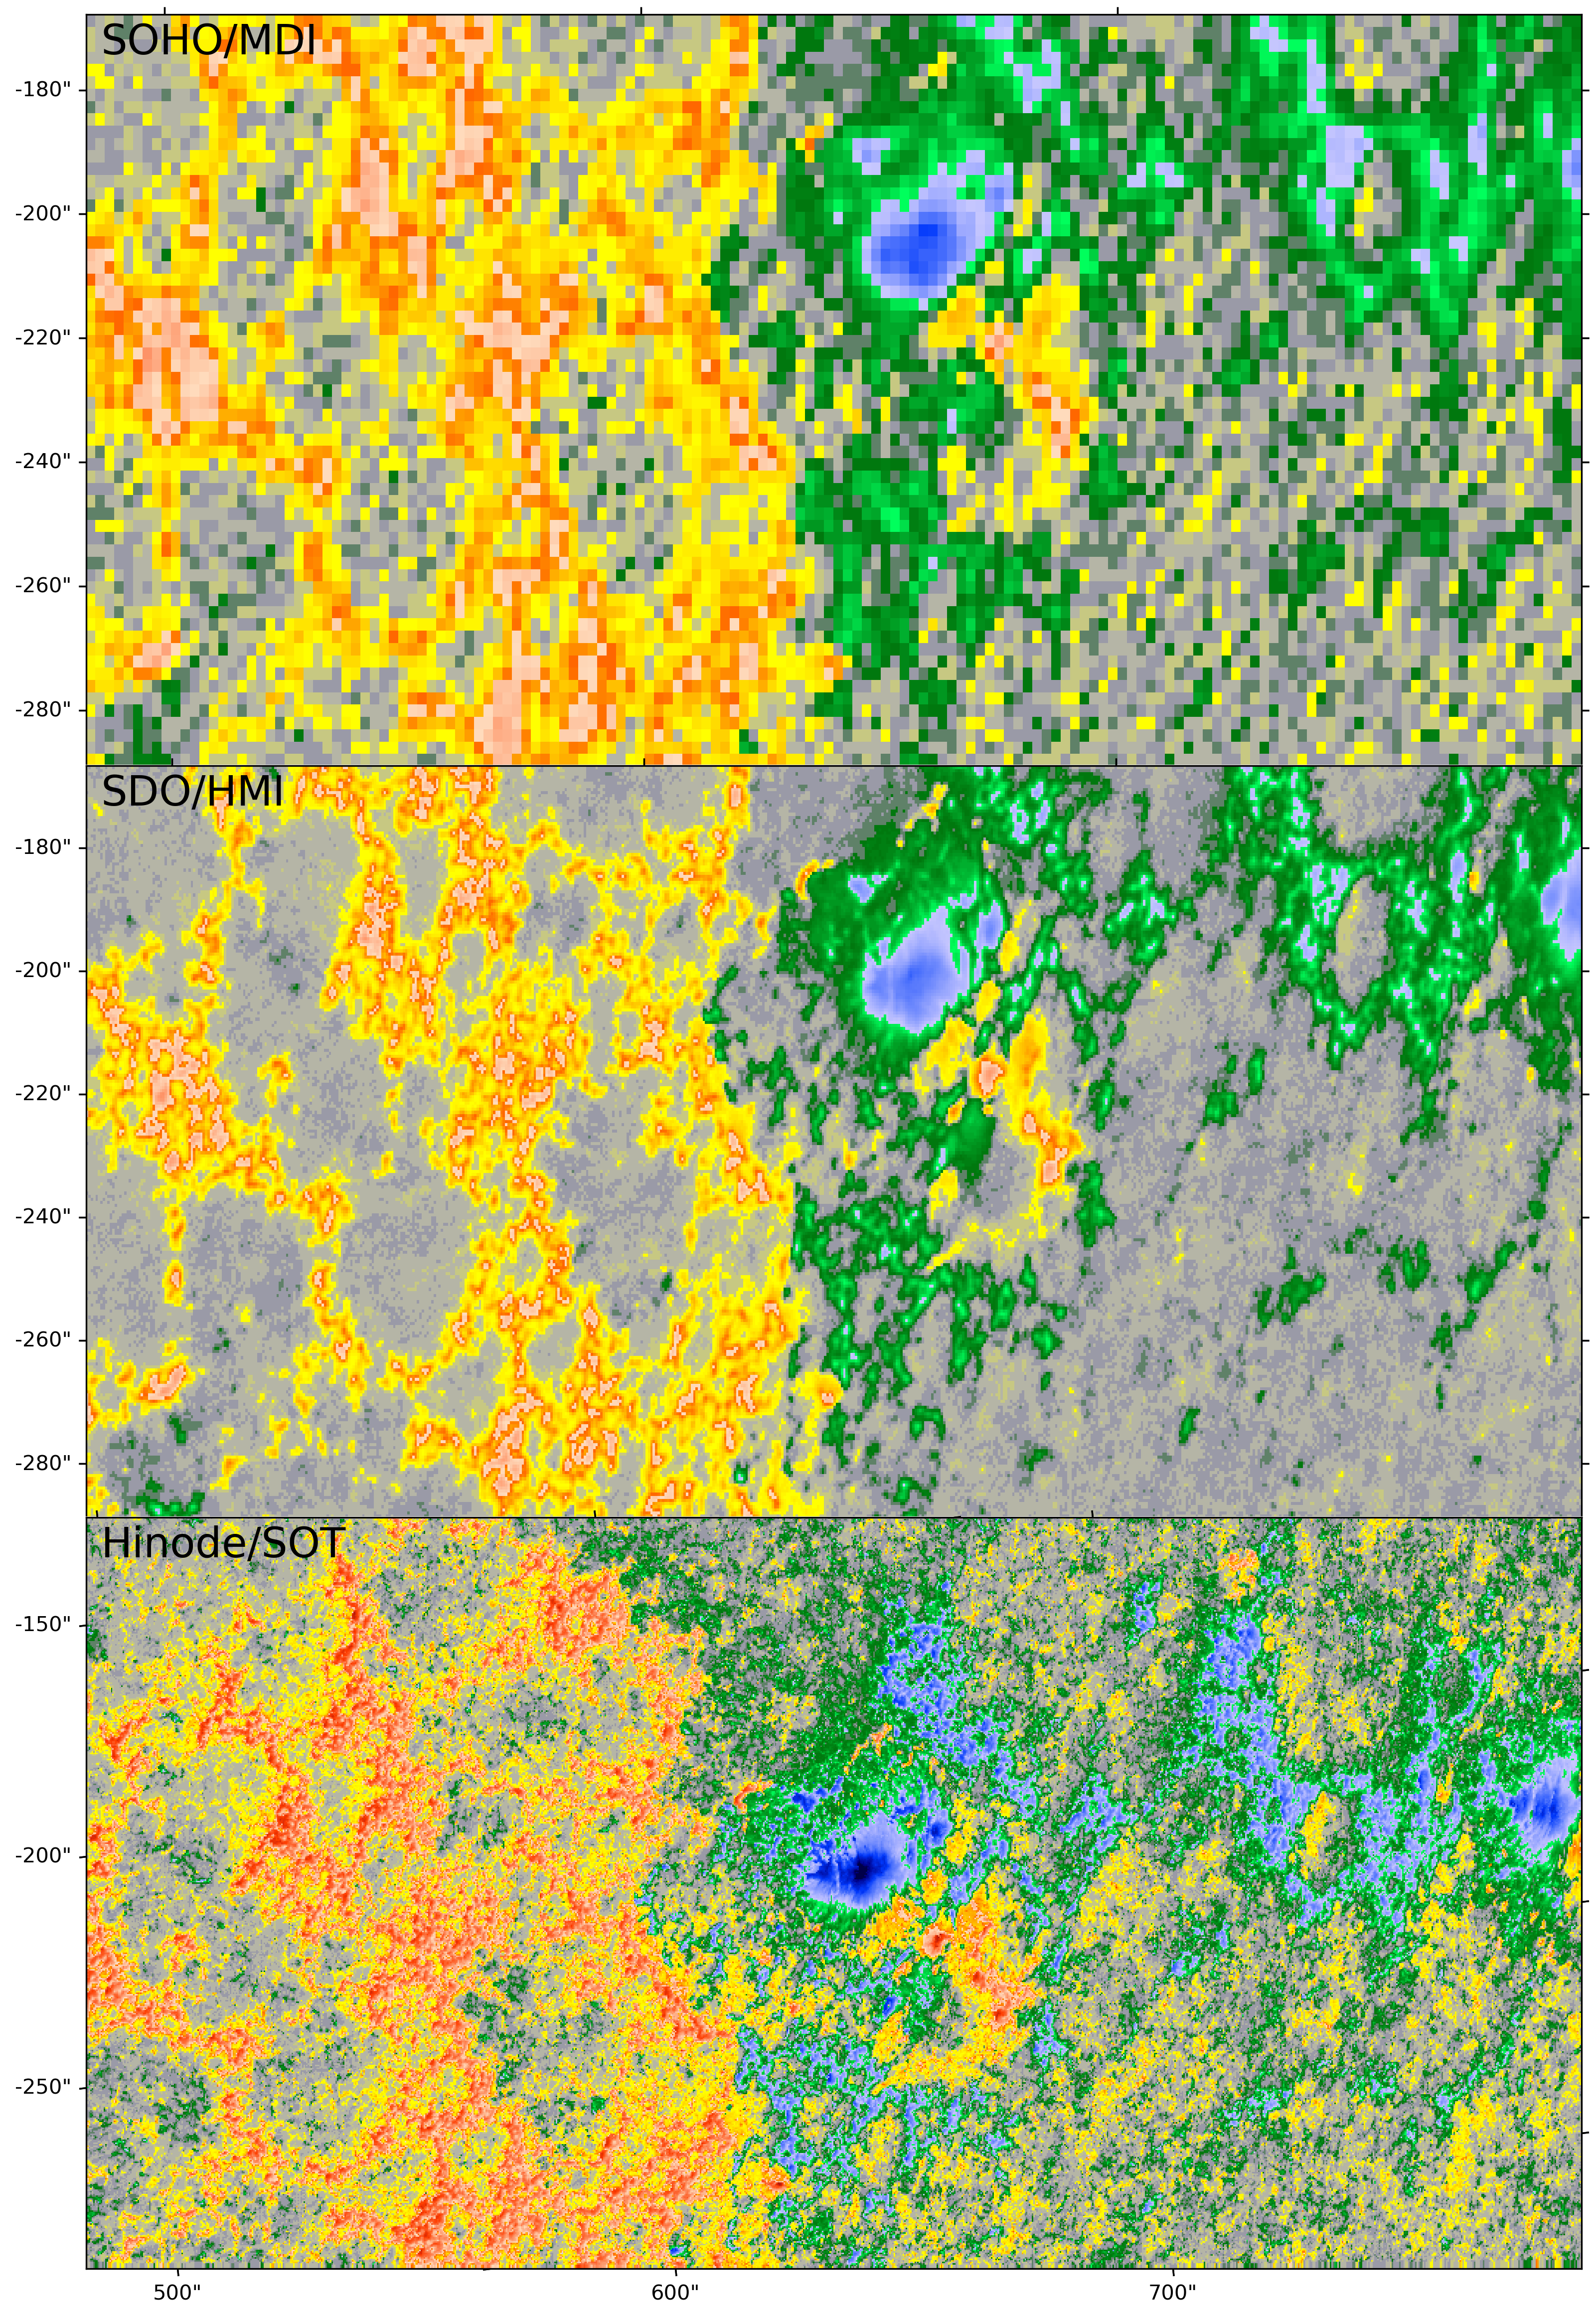

In [10]:
# Size definitions
dpi = 300
pxx = 3000   # Horizontal size of each panel
pxy = pxx*SOTmap.data.shape[0]/SOTmap.data.shape[1]   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 3     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units

# Colormaps
current_cmap = plt.cm.get_cmap('hmimag')
current_cmap.set_bad(color='black')

## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)
ax1 = fig.add_axes([ppadh, ppadv+2*ppxy, ppxx, ppxy], projection=MDISmap)

x, y = np.meshgrid(*[np.arange(v.value) for v in MDISmap.dimensions]) * u.pixel
hpc_coords = MDISmap.pixel_to_world(x, y)
ax1.pcolormesh(x, y, MDISmap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
ax1.grid(False)

ax1.text(0.01, 0.99, 'SOHO/MDI', horizontalalignment='left', verticalalignment='top', color = 'k', transform=ax1.transAxes, fontsize = 20)


ax2 = fig.add_axes([ppadh, ppadv+ppxy, ppxx, ppxy], projection=HMISmap)

x, y = np.meshgrid(*[np.arange(v.value) for v in HMISmap.dimensions]) * u.pixel
hpc_coords = HMISmap.pixel_to_world(x, y)
mesh = ax2.pcolormesh(x, y, HMISmap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
ax2.grid(False)

ax2.text(0.01, 0.99, 'SDO/HMI', horizontalalignment='left', verticalalignment='top', color = 'k', transform=ax2.transAxes, fontsize = 20)


ax3 = fig.add_axes([ppadh, ppadv, ppxx, ppxy], projection=SOTmap)


x, y = np.meshgrid(*[np.arange(v.value) for v in SOTmap.dimensions]) * u.pixel
hpc_coords = SOTmap.pixel_to_world(x, y)
mesh = ax3.pcolormesh(x, y, SOTmap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
ax3.grid(False)

ax3.text(0.01, 0.99, 'Hinode/SOT', horizontalalignment='left', verticalalignment='top', color = 'k', transform=ax3.transAxes, fontsize = 20);

In [11]:
MWFfile = 'Data/MW/m991211_1896_0na1.fits'

MWF_fits = fits.open(MWFfile, cache=False)
MWF_fits.verify('fix')
dataMWF = MWF_fits[0].data

# Adding missing header information
header = MWF_fits[0].header
header['cunit1'] = 'arcsec'
header['cunit2'] = 'arcsec'
header['CDELT1'] = header['DXB_IMG']*1.03
header['CDELT2'] = header['DYB_IMG']*1.03
header['CRVAL1'] = 0
header['CRVAL2'] = 0
header['RSUN_OBS'] = (header['R0'])*header['DXB_IMG']*1.03
header['CROTA2'] = header['B0']
header['CRPIX1'] = header['X0']
header['CRPIX2'] = header['Y0']
header['T_OBS']   = '1999.12.11_12:00:00_TAI'
header['DATE-OBS']   = '1999.12.11_12:00:00_TAI'

MWFmap = sunpy.map.Map(MWF_fits[0].data, header)
MWFmap = MWFmap.rotate(rmatrix=MWFmap.rotation_matrix, missing=np.nan, recenter=True)

MWFmap.rotation_matrix

# Apply NaNs for Pixels outside the Sun
x, y = np.meshgrid(*[np.arange(v.value) for v in MWFmap.dimensions]) * u.pixel
hpc_coords = MWFmap.pixel_to_world(x, y)
r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / MWFmap.rsun_obs
MWFmap.data[r>1] = np.nan

In [12]:
MDIfile = 'Data/MDI/mdi.fd_M_96m_lev182.19991211_000000_TAI.data.fits'

MDI_fits = fits.open(MDIfile, cache=False)
MDI_fits.verify('fix')
dataMDI = MDI_fits[1].data

MDImap = sunpy.map.Map(MDI_fits[1].data, MDI_fits[1].header)
MDImap = MDImap.rotate(rmatrix=MDImap.rotation_matrix, missing=np.nan, recenter=True)

x, y = np.meshgrid(*[np.arange(v.value) for v in MDImap.dimensions]) * u.pixel
hpc_coords = MDImap.pixel_to_world(x, y)
r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / MDImap.rsun_obs
MDImap.data[r>1] = np.nan

MDImap = MDImap.submap(MWFmap.bottom_left_coord,MWFmap.top_right_coord)

In [13]:
SPMGfile = 'Data/SPMG/spmg_eo000_C1_19991211_1740.fits'

SPMG_fits = fits.open(SPMGfile, cache=False)
SPMG_fits.verify('fix')
dataSPMG = SPMG_fits[0].data[5,:,:]

# Adding missing header information
header = SPMG_fits[0].header
header['cunit1'] = 'arcsec'
header['cunit2'] = 'arcsec'
header['CDELT1'] = header['CDELT1A']
header['CDELT2'] = header['CDELT2A']
header['CRVAL1'] = 0
header['CRVAL2'] = 0
header['RSUN_OBS'] = header['EPH_R0 ']
header['CROTA2'] = 0
header['CRPIX1'] = header['CRPIX1A']
header['CRPIX2'] = header['CRPIX2A']
header['PC2_1'] = 0
header['PC1_2'] = 0


SPMGmap = sunpy.map.Map(dataSPMG, SPMG_fits[0].header)

# # x, y = np.meshgrid(*[np.arange(v.value) for v in SPMGmap.dimensions]) * u.pixel
# # hpc_coords = SPMGmap.pixel_to_world(x, y)
# # r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / SPMGmap.rsun_obs
# # SPMGmap.data[r>1] = np.nan

SPMGmap = SPMGmap.submap(MWFmap.bottom_left_coord,MWFmap.top_right_coord)

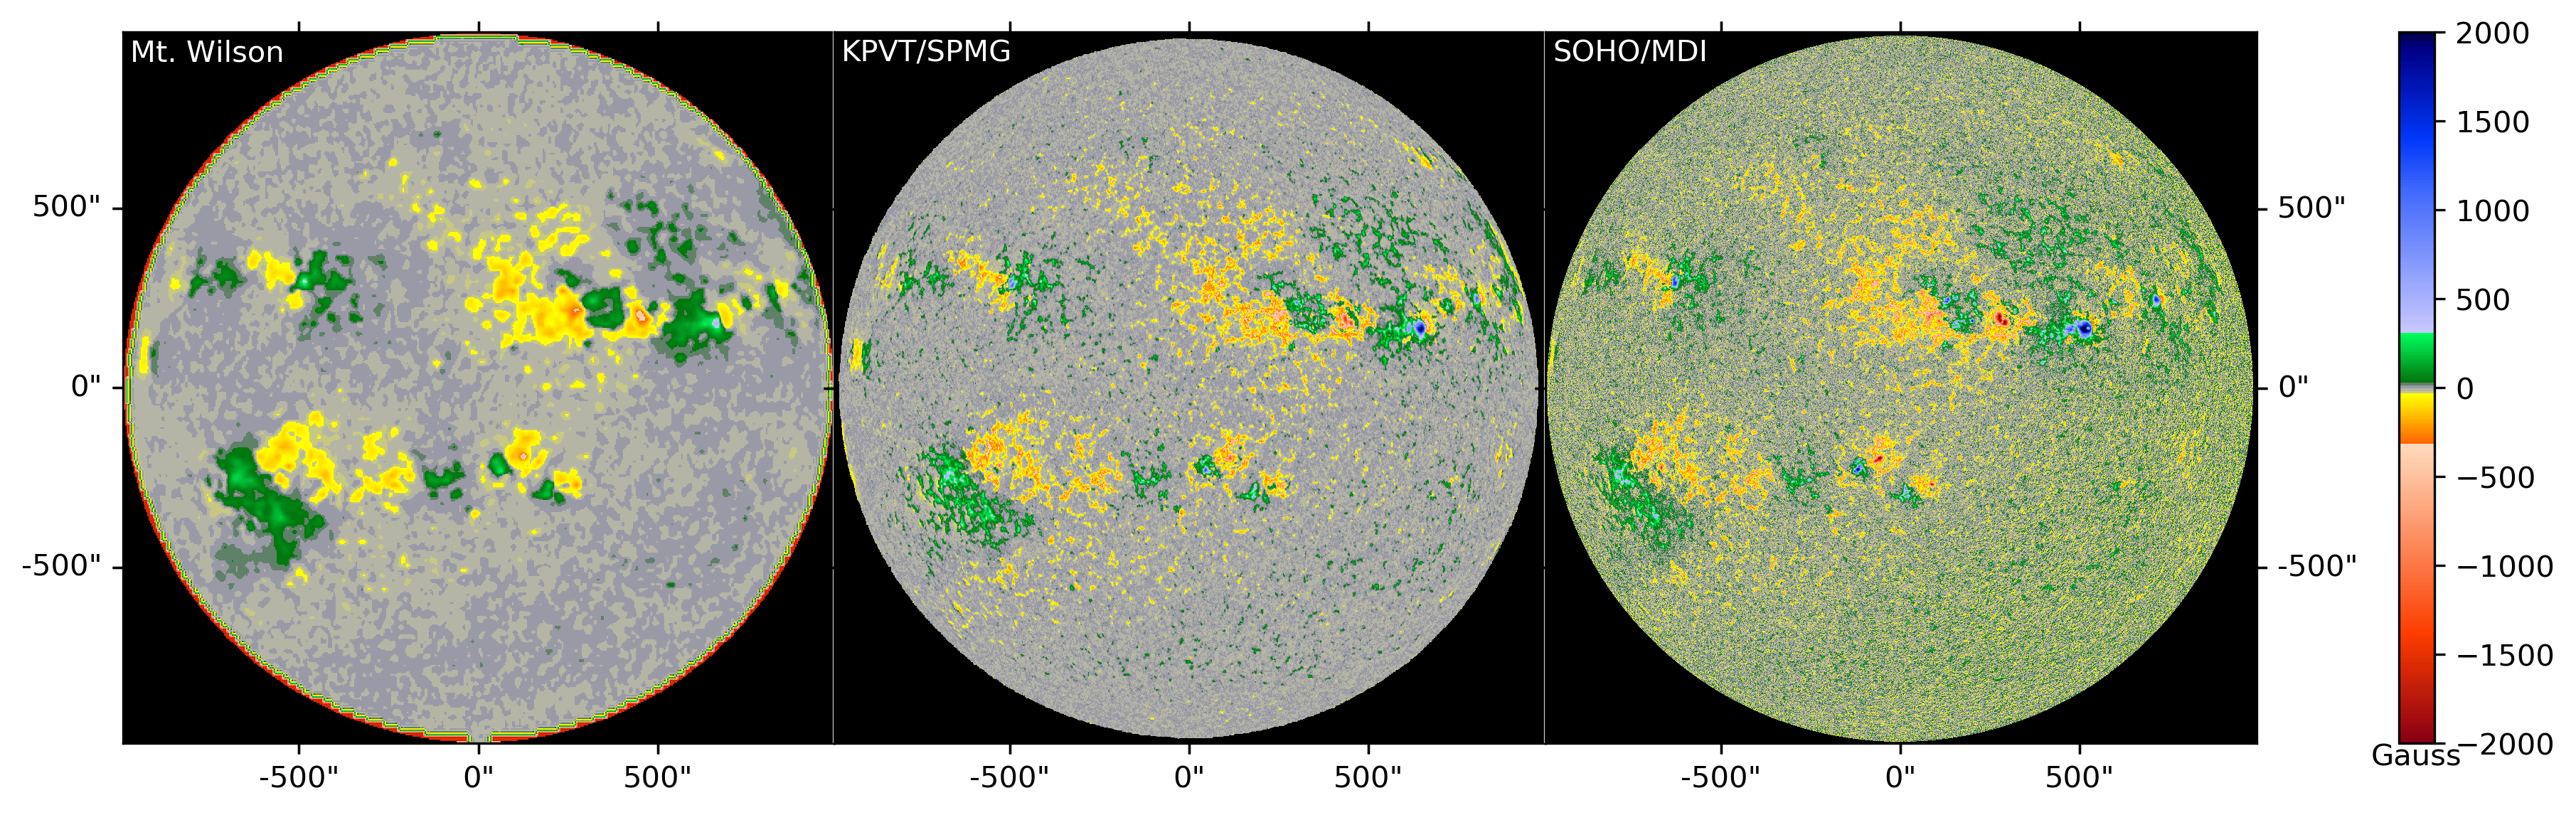

In [14]:
# Size definitions
dpi = 300
pxx = 1000   # Horizontal size of each panel
pxy = pxx   # Vertical size of each panel

nph = 2     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units

# Colormaps
current_cmap = plt.cm.get_cmap('hmimag')
current_cmap.set_bad(color='black')

## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)
ax1 = fig.add_axes([ppadh, ppadv, ppxx, ppxy], projection=MWFmap)

x, y = np.meshgrid(*[np.arange(v.value) for v in MWFmap.dimensions]) * u.pixel
hpc_coords = MWFmap.pixel_to_world(x, y)
ax1.pcolormesh(x, y, MWFmap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
ax1.grid(False)

ax1.text(0.01, 0.99, 'Mt. Wilson', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax1.transAxes)


ax2 = fig.add_axes([ppadh+ppxx, ppadv, ppxx, ppxy], projection=SPMGmap)

x, y = np.meshgrid(*[np.arange(v.value) for v in SPMGmap.dimensions]) * u.pixel
hpc_coords = SPMGmap.pixel_to_world(x, y)
ax2.pcolormesh(x, y, SPMGmap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
ax2.grid(False)
ax2.text(0.01, 0.99, 'KPVT/SPMG', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax2.transAxes)

lat = ax2.coords[1]
lat.set_ticklabel_position('r')


ax3 = fig.add_axes([ppadh+2*ppxx, ppadv, ppxx, ppxy], projection=MDImap)

x, y = np.meshgrid(*[np.arange(v.value) for v in MDImap.dimensions]) * u.pixel
hpc_coords = MDImap.pixel_to_world(x, y)
ax3.pcolormesh(x, y, MDImap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
ax3.grid(False)
ax3.text(0.01, 0.99, 'SOHO/MDI', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax3.transAxes)

lat = ax3.coords[1]
lat.set_ticklabel_position('r')

axcb = fig.add_axes([ppadh+4*ppadh2+3*ppxx, ppadv, ppadh2, ppxy])
cmap = current_cmap
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(axcb, cmap=cmap,
                                norm=norm)

axcb.text(0.5, 0, 'Gauss', horizontalalignment='center', verticalalignment='top', color = 'k', transform=axcb.transAxes);
